link to the notebook : [TCXI.ipynb](https://colab.research.google.com/drive/1nayfzRZYhe80aB-awl03m1oFSZEaGMVc?usp=sharing#scrollTo=hDdFClW63qVw)

In [ ]:
!pip install keras_facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras_facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10368 sha256=1074fcce51cb2297e464ca37bdee1fe8338fca1de34a1e0b18bd0b67b435a624
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras_facenet


In [ ]:
import os
import cv2
import numpy as np
import dlib
import tensorflow as tf
from mtcnn import MTCNN
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
import logging
from datetime import datetime
from keras_facenet import FaceNet
import pandas as pd


In [ ]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        logging.error(f"GPU configuration error: {str(e)}")


In [ ]:
class DatasetPreparator:
    def __init__(self):
        self.face_detector = MTCNN()
        self.min_face_size = (160, 160)

    def prepare_dataset(self, base_dir: str, output_dir: str) -> pd.DataFrame:
        """
        Prepares and validates the dataset.

        Args:
            base_dir: Base directory containing person folders.
            output_dir: Directory to save processed images.

        Returns:
            DataFrame with dataset statistics.
        """
        stats = []
        os.makedirs(output_dir, exist_ok=True)

        for person_name in tqdm(os.listdir(base_dir)):
            person_dir = os.path.join(base_dir, person_name)
            if not os.path.isdir(person_dir):
                continue

            processed_dir = os.path.join(output_dir, person_name)
            os.makedirs(processed_dir, exist_ok=True)

            person_stats = self._process_person_folder(person_dir, processed_dir)
            person_stats['person'] = person_name
            stats.append(person_stats)

        return pd.DataFrame(stats)

    def _process_person_folder(self, input_dir: str, output_dir: str) -> dict:
        stats = {
            'total_images': 0,
            'processed_images': 0,
            'failed_images': 0,
            'avg_face_confidence': 0.0
        }
        face_confidences = []

        for img_name in os.listdir(input_dir):
            if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            stats['total_images'] += 1
            img_path = os.path.join(input_dir, img_name)

            try:
                result = self._process_single_image(img_path, output_dir)
                if result['success']:
                    stats['processed_images'] += 1
                    face_confidences.append(result['confidence'])
                else:
                    stats['failed_images'] += 1
            except Exception as e:
                logging.error(f"Error processing {img_path}: {str(e)}")
                stats['failed_images'] += 1

        if face_confidences:
            stats['avg_face_confidence'] = np.mean(face_confidences)

        return stats

    def _process_single_image(self, img_path: str, output_dir: str) -> dict:
        image = cv2.imread(img_path)
        if image is None:
            return {'success': False}

        faces = self.face_detector.detect_faces(image)
        if not faces:
            return {'success': False}

        face = max(faces, key=lambda x: x['confidence'])
        if face['confidence'] < 0.95:
            return {'success': False}

        x, y, w, h = face['box']
        face_img = image[y:y+h, x:x+w]
        face_img = cv2.resize(face_img, (160, 160))

        output_path = os.path.join(output_dir, os.path.basename(img_path))
        cv2.imwrite(output_path, face_img)

        return {
            'success': True,
            'confidence': face['confidence']
        }


In [ ]:
# Training Configuration
RAW_DATASET_PATH = "dataset/raw_dataset"
PROCESSED_DATASET_PATH = "processed_dataset"
MODEL_OUTPUT_DIR = "model_output"

#  Prepare Dataset
logging.info("Preparing the dataset...")
preparator = DatasetPreparator()
stats_df = preparator.prepare_dataset(RAW_DATASET_PATH, PROCESSED_DATASET_PATH)




  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
import zipfile
import os


zip_file_path = 'dataset.zip'
dataset_path = 'dataset/'


if not os.path.exists(dataset_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
        print("Dataset extracted successfully!")

Dataset extracted successfully!


In [ ]:
import os

def rename_images(base_path):
    """
    Rename all images in each subfolder of the base_path to a consistent format: img1.jpg, img2.jpg, etc.

    Args:
        base_path (str): Path to the dataset folder where each subfolder represents a class/person.
    """
    for person_name in os.listdir(base_path):
        person_folder = os.path.join(base_path, person_name)

        if os.path.isdir(person_folder):
            print(f"Renaming images for: {person_name}")

            # List all files in the folder
            images = sorted(os.listdir(person_folder))

            for i, img_name in enumerate(images):
                img_path = os.path.join(person_folder, img_name)

                # Generate the new name
                new_name = f"img{i+1}.jpg"
                new_path = os.path.join(person_folder, new_name)

                # Rename the file
                os.rename(img_path, new_path)
                print(f"Renamed: {img_name} -> {new_name}")

    print("Renaming completed!")


dataset_path = "dataset/raw_dataset"

rename_images(dataset_path)


Renaming images for: Megan Fox
Renamed: 001_dfb62d96.jpg -> img1.jpg
Renamed: 002_6e289116.jpg -> img2.jpg
Renamed: 003_61dd1e53.jpg -> img3.jpg
Renamed: 004_6aede3d3.jpg -> img4.jpg
Renamed: 005_9574c208.jpg -> img5.jpg
Renamed: 006_4e33c943.jpg -> img6.jpg
Renamed: 007_e3073d58.jpg -> img7.jpg
Renamed: 008_74bda018.jpg -> img8.jpg
Renamed: 009_3283c30e.jpg -> img9.jpg
Renamed: 010_0479e335.jpg -> img10.jpg
Renamed: 011_b2354fd0.jpg -> img11.jpg
Renamed: 012_d461a2b5.jpg -> img12.jpg
Renamed: 013_f4968d00.jpg -> img13.jpg
Renamed: 014_d6e920d4.jpg -> img14.jpg
Renamed: 015_b4a21d28.jpg -> img15.jpg
Renamed: 016_bd51d057.jpg -> img16.jpg
Renamed: 017_eed36648.jpg -> img17.jpg
Renamed: 018_394cfad7.jpg -> img18.jpg
Renamed: 019_8e696057.jpg -> img19.jpg
Renamed: 020_467a9bd7.jpg -> img20.jpg
Renamed: 021_2d9dd3a2.jpg -> img21.jpg
Renamed: 022_784eea3c.jpg -> img22.jpg
Renamed: 023_55dd20e3.jpg -> img23.jpg
Renamed: 024_2c2a7324.jpg -> img24.jpg
Renamed: 025_b7dee9f2.jpg -> img25.jpg
Ren

In [ ]:
!pip install tensorflow numpy scikit-learn


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Set paths
data_dir = "processed_dataset"
image_size = (160, 160)
batch_size = 32
num_classes = len(os.listdir(data_dir))  # Automatically detect the number of classes

# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',  # Sparse categorical labels (integer encoded)
    subset='training'
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

# Transfer Learning with MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
base_model.trainable = False  # Freeze pre-trained layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Compute class weights (if dataset is imbalanced)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=40,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

# Evaluate the model
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Save the model
model.save("face_recognition_model.h5")

# Classification Report and Confusion Matrix
val_preds = np.argmax(model.predict(val_data), axis=-1)
print(classification_report(val_data.classes, val_preds, target_names=list(train_data.class_indices.keys())))
print(confusion_matrix(val_data.classes, val_preds))

Found 1363 images belonging to 17 classes.
Found 335 images belonging to 17 classes.
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 369ms/step - accuracy: 0.0714 - loss: 3.1739 - val_accuracy: 0.1731 - val_loss: 2.5503
Epoch 2/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 287ms/step - accuracy: 0.1485 - loss: 2.5939 - val_accuracy: 0.2955 - val_loss: 2.2839
Epoch 3/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 206ms/step - accuracy: 0.2016 - loss: 2.4007 - val_accuracy: 0.3493 - val_loss: 2.0078
Epoch 4/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 244ms/step - accuracy: 0.2528 - loss: 2.1925 - val_accuracy: 0.3881 - val_loss: 1.9396
Epoch 5/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 248ms/step - accuracy: 0.2985 - loss: 2.0474 - val_accuracy: 0.4866 - val_loss: 1.7839
Epoch 6/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - accuracy: 0.3067 - loss: 2.0018 - val_accuracy: 0.5284 - val_loss: 1.5836
Epoch 7/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step - accuracy: 0.3393 - loss: 1.8941 - val_accuracy: 0.4955 - val_loss: 1.5298
Epoch 8/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - accuracy: 0.3409 - loss: 1.9226 - val_accuracy: 0.477

Validation Accuracy: 68.66%
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 357ms/step
                    precision    recall  f1-score   support

    Angelina Jolie       0.00      0.00      0.00        19
         Brad Pitt       0.05      0.05      0.05        19
 Denzel Washington       0.19      0.22      0.21        18
      Hugh Jackman       0.06      0.05      0.05        19
 Jennifer Lawrence       0.00      0.00      0.00        19
       Johnny Depp       0.05      0.06      0.05        18
      Kate Winslet       0.06      0.11      0.08        18
 Leonardo DiCaprio       0.06      0.05      0.06        19
         Megan Fox       0.00      0.00      0.00        19
   Natalie Portman       0.08      0.11      0.09        19
     Nicole Kidman       0.17      0.11      0.13        19
  Robert Downey Jr       0.12      0.11      0.12        18
    Sandra Bullock       0.00      0.00      0.00        18
Scarlett Johansson       0.07      0.05      0.06        39
        Tom Cruise       0.11 

In [ ]:
# Test Data Preparation
test_data = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Predictions on the test dataset
test_preds = np.argmax(model.predict(test_data), axis=-1)

# Classification Report and Confusion Matrix for Test Data
print("Classification Report for Test Data:")
print(classification_report(test_data.classes, test_preds, target_names=list(train_data.class_indices.keys())))

print("Confusion Matrix for Test Data:")
print(confusion_matrix(test_data.classes, test_preds))


Found 335 images belonging to 17 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.6989 - loss: 1.0808
Test Accuracy: 68.66%
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step
Classification Report for Test Data:
                    precision    recall  f1-score   support

    Angelina Jolie       0.48      0.74      0.58        19
         Brad Pitt       0.64      0.74      0.68        19
 Denzel Washington       0.78      1.00      0.88        18
      Hugh Jackman       0.80      0.84      0.82        19
 Jennifer Lawrence       0.73      0.58      0.65        19
       Johnny Depp       0.79      0.83      0.81        18
      Kate Winslet       0.48      0.61      0.54        18
 Leonardo DiCaprio       0.71      0.63      0.67        19
         Megan Fox       0.64      0.84      0.73        19
   Natalie Portman       0.37      0.37      0.37        19
     Nicole Kidman       0.83      0.53      0.65        19
  Robert Downey Jr       0.92      0.61      0.73        18
    Sandra Bullock       0.73      0.44     

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


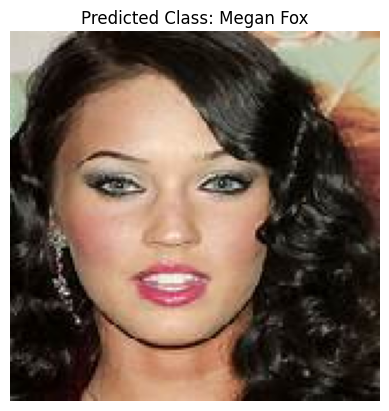

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Path to the image for test
image_path = '009_3283c30e.jpg'

# Load the image and resize it to the expected input size
img = image.load_img(image_path, target_size=image_size)

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to create a batch of size 1 (as the model expects batches)
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (same preprocessing as for the training data)
img_array = img_array / 255.0

# Predict the class of the image
predictions = model.predict(img_array)

# Get the predicted class (index)
predicted_class_index = np.argmax(predictions, axis=-1)

# Get the predicted class label
class_labels = list(train_data.class_indices.keys())  # Use the same class names from training
predicted_class_label = class_labels[predicted_class_index[0]]

# Plot the image and display the predicted class
plt.imshow(img)
plt.axis('off')  # Hide axes for better presentation
plt.title(f"Predicted Class: {predicted_class_label}")
plt.show()

